In [ ]:
# ============================================================
# 📘 OCT Classification with ConvNeXt + Grad-CAM Visualization
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch.nn.functional as F

# ============================================================
# 🔧 Data Preparation & Augmentation
# ============================================================

transform = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

data_dir = "/kaggle/input/retina-additional-normal/RetinalOCT_Dataset_final"
image_datasets = {
    'train': datasets.ImageFolder(root=f"{data_dir}/train", transform=transform['train']),
    'val': datasets.ImageFolder(root=f"{data_dir}/val", transform=transform['val']),
    'test': datasets.ImageFolder(root=f"{data_dir}/test", transform=transform['test'])
}

# ============================================================
# ⚖️ Weighted Sampling to handle class imbalance
# ============================================================

targets = [label for _, label in image_datasets['train'].imgs]
class_counts = np.bincount(targets)
class_weights = 1. / (class_counts + 1e-8)
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, sampler=sampler, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=2)
}

class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ============================================================
# 🧠 Model Setup: ConvNeXt-Base (pretrained)
# ============================================================

weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model = convnext_base(weights=weights)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, verbose=True)

# ============================================================
# 🚀 Training Loop with Early Stopping
# ============================================================

epochs = 10
best_acc = 0.0
patience = 3
no_improve = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-"*25)

    # ----- TRAIN -----
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in tqdm(dataloaders['train'], desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(image_datasets['train'])
    train_acc = running_corrects.double() / len(image_datasets['train'])
    print(f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")

    # ----- VALIDATION -----
    model.eval()
    val_corrects = 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            val_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_acc = val_corrects.double() / len(image_datasets['val'])
    print(f"Val Acc: {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        no_improve = 0
        print("Model improved and saved.")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

# ============================================================
# 🧾 Final Evaluation
# ============================================================

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nFinal Validation Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:02<00:00, 175MB/s]  
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10
-------------------------


Train Loss: 0.8711  Acc: 0.8173


Val Acc: 0.9393
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.94      0.92      0.93       350
         CSR       0.93      1.00      0.96       350
         DME       0.91      0.89      0.90       350
          DR       0.99      0.95      0.97       350
      DRUSEN       0.93      0.86      0.89       350
          MH       0.99      0.97      0.98       350
      NORMAL       0.84      0.93      0.88       350

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800

✅ Model improved and saved.

Epoch 2/10
-------------------------


Train Loss: 0.6635  Acc: 0.9194


Val Acc: 0.9257
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      0.98      0.99       350
         CNV       0.98      0.80      0.88       350
         CSR       0.98      1.00      0.99       350
         DME       0.96      0.78      0.86       350
          DR       0.99      0.97      0.98       350
      DRUSEN       0.82      0.92      0.86       350
          MH       0.96      0.99      0.97       350
      NORMAL       0.79      0.97      0.87       350

    accuracy                           0.93      2800
   macro avg       0.93      0.93      0.93      2800
weighted avg       0.93      0.93      0.93      2800


Epoch 3/10
-------------------------


Train Loss: 0.6369  Acc: 0.9302


Val Acc: 0.9364
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.93      0.85      0.89       350
         CSR       0.97      1.00      0.98       350
         DME       0.93      0.87      0.90       350
          DR       0.99      0.97      0.98       350
      DRUSEN       0.87      0.85      0.86       350
          MH       1.00      0.99      0.99       350
      NORMAL       0.82      0.96      0.88       350

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800


Epoch 4/10
-------------------------


Train Loss: 0.6096  Acc: 0.9394


Val Acc: 0.9529
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.90      0.95      0.92       350
         CSR       0.97      1.00      0.99       350
         DME       0.96      0.90      0.93       350
          DR       0.99      1.00      0.99       350
      DRUSEN       0.95      0.82      0.88       350
          MH       1.00      0.97      0.98       350
      NORMAL       0.87      0.98      0.92       350

    accuracy                           0.95      2800
   macro avg       0.95      0.95      0.95      2800
weighted avg       0.95      0.95      0.95      2800

✅ Model improved and saved.

Epoch 5/10
-------------------------


Train Loss: 0.6105  Acc: 0.9410


Val Acc: 0.9254
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      0.99      0.99       350
         CNV       0.91      0.92      0.92       350
         CSR       0.89      1.00      0.94       350
         DME       0.98      0.82      0.89       350
          DR       1.00      0.84      0.91       350
      DRUSEN       0.91      0.89      0.90       350
          MH       0.99      0.97      0.98       350
      NORMAL       0.78      0.98      0.87       350

    accuracy                           0.93      2800
   macro avg       0.93      0.93      0.93      2800
weighted avg       0.93      0.93      0.93      2800


Epoch 6/10
-------------------------


Train Loss: 0.5949  Acc: 0.9464


Val Acc: 0.9486
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      0.99      1.00       350
         CNV       0.96      0.92      0.94       350
         CSR       1.00      1.00      1.00       350
         DME       0.95      0.84      0.89       350
          DR       1.00      0.99      0.99       350
      DRUSEN       0.92      0.86      0.89       350
          MH       0.99      1.00      0.99       350
      NORMAL       0.80      0.99      0.89       350

    accuracy                           0.95      2800
   macro avg       0.95      0.95      0.95      2800
weighted avg       0.95      0.95      0.95      2800


Epoch 7/10
-------------------------


Train Loss: 0.5910  Acc: 0.9481


Val Acc: 0.9579
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.95      0.92      0.94       350
         CSR       1.00      0.99      0.99       350
         DME       0.92      0.95      0.93       350
          DR       0.99      0.96      0.98       350
      DRUSEN       0.92      0.92      0.92       350
          MH       0.95      1.00      0.97       350
      NORMAL       0.93      0.93      0.93       350

    accuracy                           0.96      2800
   macro avg       0.96      0.96      0.96      2800
weighted avg       0.96      0.96      0.96      2800

✅ Model improved and saved.

Epoch 8/10
-------------------------


Train Loss: 0.6011  Acc: 0.9435


Val Acc: 0.9664
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      0.99      1.00       350
         CNV       0.93      0.95      0.94       350
         CSR       0.99      1.00      0.99       350
         DME       0.96      0.92      0.94       350
          DR       1.00      0.99      1.00       350
      DRUSEN       0.94      0.91      0.93       350
          MH       1.00      1.00      1.00       350
      NORMAL       0.92      0.97      0.94       350

    accuracy                           0.97      2800
   macro avg       0.97      0.97      0.97      2800
weighted avg       0.97      0.97      0.97      2800

✅ Model improved and saved.

Epoch 9/10
-------------------------


Train Loss: 0.5797  Acc: 0.9530


Val Acc: 0.9368
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.97      0.89      0.93       350
         CSR       0.90      1.00      0.95       350
         DME       0.97      0.85      0.91       350
          DR       1.00      0.89      0.94       350
      DRUSEN       0.91      0.88      0.89       350
          MH       0.99      0.99      0.99       350
      NORMAL       0.81      1.00      0.89       350

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800


Epoch 10/10
-------------------------


Train Loss: 0.5697  Acc: 0.9576


Val Acc: 0.9389
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       1.00      0.72      0.84       350
         CSR       1.00      0.97      0.99       350
         DME       0.88      0.98      0.93       350
          DR       0.96      1.00      0.98       350
      DRUSEN       0.78      0.97      0.86       350
          MH       1.00      0.99      1.00       350
      NORMAL       0.96      0.88      0.92       350

    accuracy                           0.94      2800
   macro avg       0.95      0.94      0.94      2800
weighted avg       0.95      0.94      0.94      2800


Final Validation Report:
              precision    recall  f1-score   support

         AMD       1.00      0.99      1.00       350
         CNV       0.93      0.95      0.94       350
         CSR       0.99      1.00      0.99       350
         DME       0.96      0.92      0.94       350
          DR 

Final Validation Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.95      0.93      0.94       350
         CSR       1.00      1.00      1.00       350
         DME       0.93      0.95      0.94       350
          DR       1.00      1.00      1.00       350
      DRUSEN       0.94      0.93      0.93       350
          MH       1.00      1.00      1.00       350
      NORMAL       0.94      0.95      0.95       350

    accuracy                           0.97      2800
   macro avg       0.97      0.97      0.97      2800
weighted avg       0.97      0.97      0.97      2800


Sample Predictions (Validation set):


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


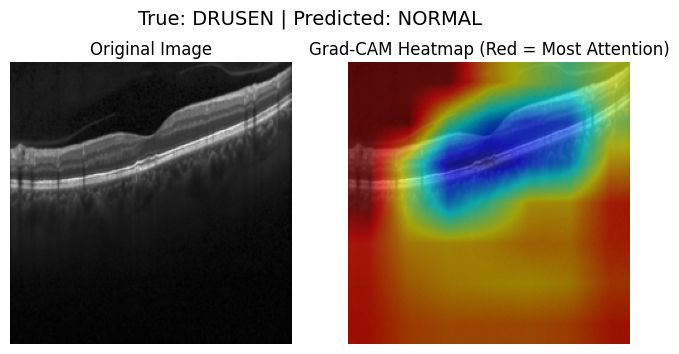


True Label: DRUSEN, Predicted: NORMAL
  AMD: 0.0000
  CNV: 0.0007
  CSR: 0.0000
  DME: 0.0037
  DR: 0.0000
  DRUSEN: 0.0352
  MH: 0.0000
  NORMAL: 0.9604


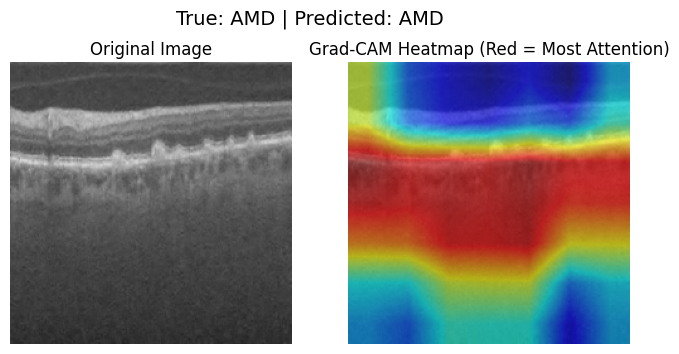


True Label: AMD, Predicted: AMD
  AMD: 1.0000
  CNV: 0.0000
  CSR: 0.0000
  DME: 0.0000
  DR: 0.0000
  DRUSEN: 0.0000
  MH: 0.0000
  NORMAL: 0.0000


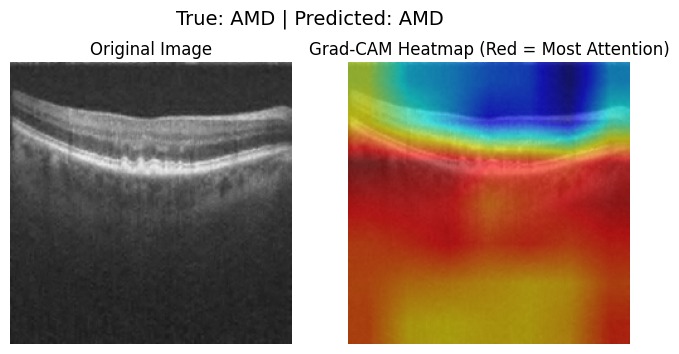


True Label: AMD, Predicted: AMD
  AMD: 1.0000
  CNV: 0.0000
  CSR: 0.0000
  DME: 0.0000
  DR: 0.0000
  DRUSEN: 0.0000
  MH: 0.0000
  NORMAL: 0.0000


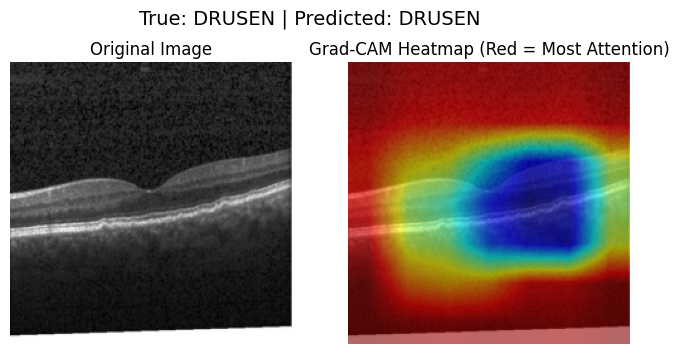


True Label: DRUSEN, Predicted: DRUSEN
  AMD: 0.0000
  CNV: 0.0018
  CSR: 0.0000
  DME: 0.0000
  DR: 0.0000
  DRUSEN: 0.9982
  MH: 0.0000
  NORMAL: 0.0000


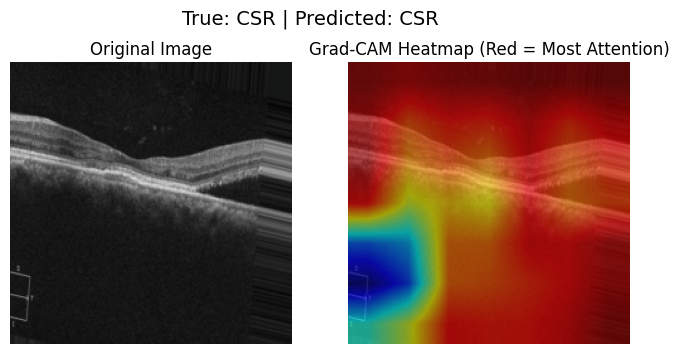


True Label: CSR, Predicted: CSR
  AMD: 0.0000
  CNV: 0.0000
  CSR: 0.9992
  DME: 0.0000
  DR: 0.0000
  DRUSEN: 0.0000
  MH: 0.0008
  NORMAL: 0.0000


In [4]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from sklearn.metrics import classification_report

# --- Load trained model ---
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model.eval()

# --- Compute Validation Classification Report ---
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Final Validation Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# --- Grad-CAM Implementation ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        grads = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (grads * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224,224), mode='bilinear', align_corners=False)
        cam = cam[0,0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# --- Grad-CAM setup (adjust for your model type) ---
# Example: for DenseNet use model.features.denseblock4; for ResNet use model.layer4
target_layer = model.features[-1][2]
grad_cam = GradCAM(model, target_layer)

# --- Helper: show images ---
def deprocess_image(tensor):
    image = tensor.cpu().numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

print("\nSample Predictions (Validation set):")
inputs, labels = next(iter(dataloaders['test']))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
probs = F.softmax(outputs, dim=1)

# --- Visualize predictions + Grad-CAM ---
for i in range(min(5, inputs.size(0))):
    input_tensor = inputs[i].unsqueeze(0)
    true_label = class_names[labels[i]]
    pred_idx = torch.argmax(probs[i]).item()
    pred_label = class_names[pred_idx]

    # Generate Grad-CAM
    cam = grad_cam.generate(input_tensor, pred_idx)

    # Prepare visualization
    img_np = deprocess_image(inputs[i])
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = 0.6 * heatmap + 0.4 * img_np
    overlay = np.clip(overlay, 0, 1)

    # Display
    plt.figure(figsize=(8,4))
    plt.suptitle(f"True: {true_label} | Predicted: {pred_label}", fontsize=14)
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap (Red = Most Attention)")
    plt.axis("off")
    plt.show()

    # Print probabilities
    print(f"\nTrue Label: {true_label}, Predicted: {pred_label}")
    for cls, prob in zip(class_names, probs[i].detach().cpu().numpy()):
        print(f"  {cls}: {prob:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


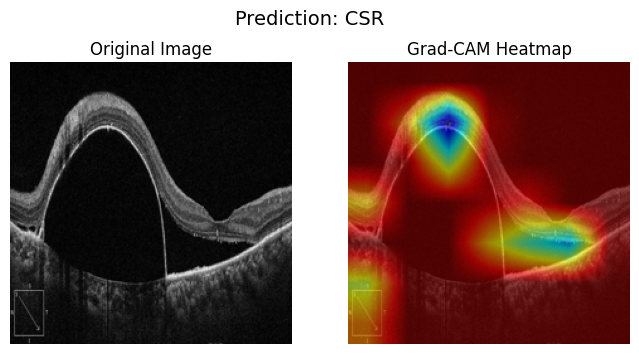


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.17 PM.jpeg
Predicted Class: CSR
  AMD: 0.0097
  CNV: 0.0162
  CSR: 0.9116
  DME: 0.0189
  DR: 0.0110
  DRUSEN: 0.0127
  MH: 0.0091
  NORMAL: 0.0107


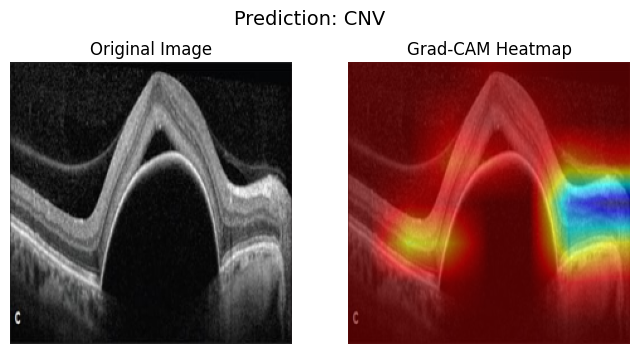


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.19 PM.jpeg
Predicted Class: CNV
  AMD: 0.0097
  CNV: 0.8120
  CSR: 0.0905
  DME: 0.0459
  DR: 0.0128
  DRUSEN: 0.0080
  MH: 0.0104
  NORMAL: 0.0109


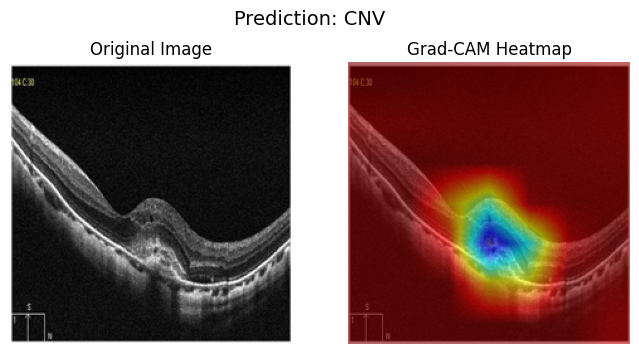


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.28 PM.jpeg
Predicted Class: CNV
  AMD: 0.0077
  CNV: 0.5777
  CSR: 0.1818
  DME: 0.0378
  DR: 0.0304
  DRUSEN: 0.0059
  MH: 0.1532
  NORMAL: 0.0055


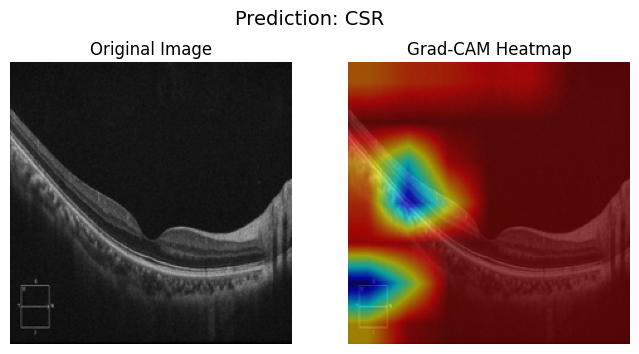


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.41 PM.jpeg
Predicted Class: CSR
  AMD: 0.0074
  CNV: 0.0070
  CSR: 0.8311
  DME: 0.0087
  DR: 0.0173
  DRUSEN: 0.0351
  MH: 0.0223
  NORMAL: 0.0711


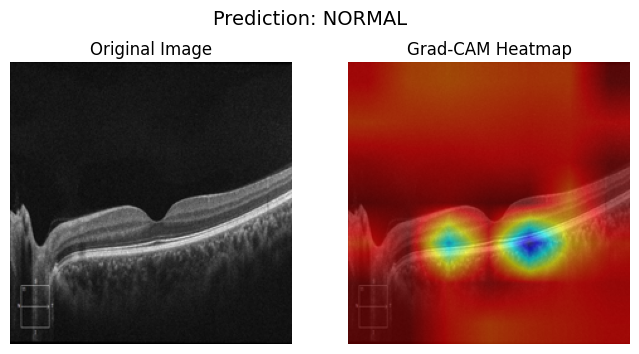


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.47 PM.jpeg
Predicted Class: NORMAL
  AMD: 0.0124
  CNV: 0.0093
  CSR: 0.0469
  DME: 0.0069
  DR: 0.0260
  DRUSEN: 0.0273
  MH: 0.0415
  NORMAL: 0.8299


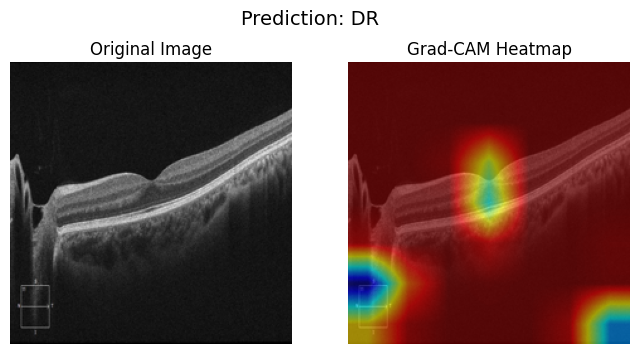


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.49 PM.jpeg
Predicted Class: DR
  AMD: 0.0175
  CNV: 0.0065
  CSR: 0.0556
  DME: 0.0072
  DR: 0.5011
  DRUSEN: 0.0249
  MH: 0.0415
  NORMAL: 0.3457


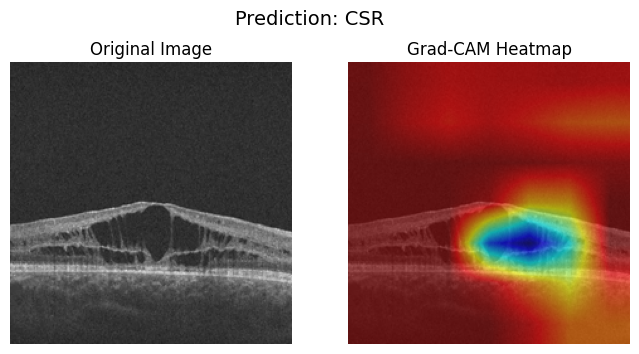


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.17 PM(2).jpeg
Predicted Class: CSR
  AMD: 0.0121
  CNV: 0.0164
  CSR: 0.7029
  DME: 0.0425
  DR: 0.1912
  DRUSEN: 0.0118
  MH: 0.0155
  NORMAL: 0.0076


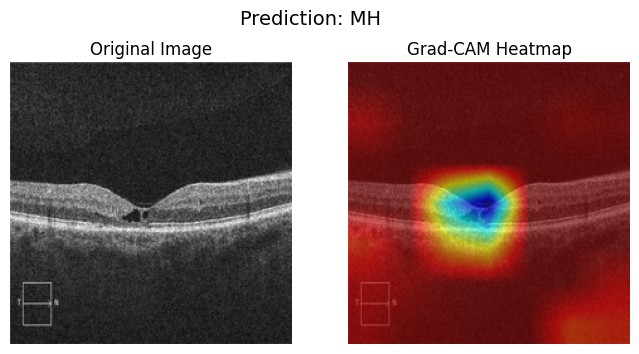


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.17 PM.jpeg
Predicted Class: MH
  AMD: 0.0095
  CNV: 0.0115
  CSR: 0.0805
  DME: 0.0127
  DR: 0.2333
  DRUSEN: 0.0096
  MH: 0.6329
  NORMAL: 0.0100


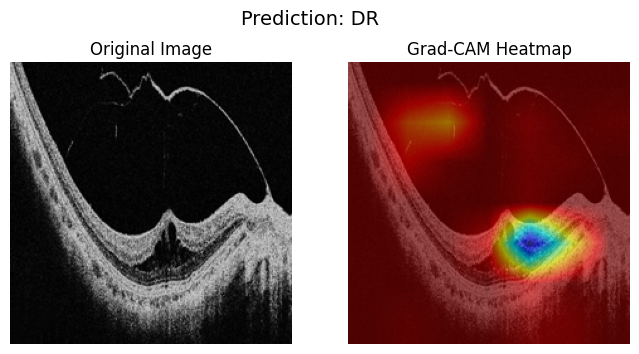


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.18 PM.jpeg
Predicted Class: DR
  AMD: 0.0075
  CNV: 0.0538
  CSR: 0.3244
  DME: 0.0342
  DR: 0.4899
  DRUSEN: 0.0143
  MH: 0.0700
  NORMAL: 0.0059


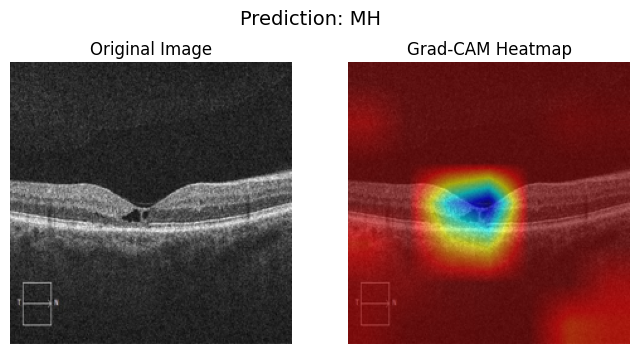


Image: /kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.19 PM.jpeg
Predicted Class: MH
  AMD: 0.0091
  CNV: 0.0108
  CSR: 0.0697
  DME: 0.0117
  DR: 0.1981
  DRUSEN: 0.0095
  MH: 0.6815
  NORMAL: 0.0095


In [2]:
# --- Load trained model ---
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model.eval()
# ============================================================
# 🔥 Grad-CAM Visualization
# ============================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        grads = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (grads * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224,224), mode='bilinear', align_corners=False)
        cam = cam[0,0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# --- Target layer for ConvNeXt ---
target_layer = model.features[-1][2]
grad_cam = GradCAM(model, target_layer)

# --- Images for Grad-CAM visualization ---
image_paths = [
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.17 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.19 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.28 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.41 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.47 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.36.49 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.17 PM(2).jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.17 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.18 PM.jpeg",
    "/kaggle/input/oct-model/WhatsApp Image 2025-09-19 at 3.37.19 PM.jpeg"
]

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, 1).item()

    cam = grad_cam.generate(input_tensor, pred_idx)

    original_img = np.array(img.resize((224,224))) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = 0.6 * heatmap + 0.4 * original_img
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(8,4))
    plt.suptitle(f"Prediction: {class_names[pred_idx]}", fontsize=14)
    plt.subplot(1,2,1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

    print(f"\nImage: {img_path}")
    print(f"Predicted Class: {class_names[pred_idx]}")
    for cls, prob in zip(class_names, probs[0].cpu().numpy()):
        print(f"  {cls}: {prob:.4f}")